<div class="alert alert-success text-left">
<img src="./rsc/logo_UTN.svg" align="right" width="150" /> 
<center> <h1>Tarea Semanal 9: Filtros Digitales</h1></center>
<h3> Teoría de circuitos 2 </h3>
<h3> 2do Cuatrimestre 2023 </h3>    
<h3> Facundo N. Iglesias </h3>    
</div>

<div class="alert alert-success text-left">

<img src="./rsc/logo_UTN.svg" align="right" width="150" /> 

<center> <h1>INDICE</h1></center>
    
</div>

0. [LIBRERIAS](#lib)

1. [PARTE 1](#parte1)
    - [1.1 Diseño filtro IIR](#1.1)
    - [1.2 Diseño filtro FIR](#1.2)
    
    
2. [PARTE 2](#parte2)
    - [2.1 Filtado con IIR](#2.1)
    - [2.2 Filtrado con FIR](#2.2)
    - [2.3 Filtrado den banda de paso](#2.3)


<div class="alert alert-success text-left">
<img src="./rsc/logo_UTN.svg" align="right" width="150" /> 
<center> 
    <a name="lib">
        <h1> LIBRERIAS</h1>
    </a> 
</center>
</div>

In [1]:
#Numeric
import numpy as np
from numpy import sqrt
#Simbolic
import sympy as sp
from sympy.abc import s
from sympy.parsing.sympy_parser import parse_expr
from sympy.solvers import solve
#Visual & graphs
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import IFrame, display, Math
from sympy.physics.control.lti import TransferFunction
from sympy.physics.control.control_plots import pole_zero_plot
#Simulation
import scipy.signal as sig
from pytc2.sistemas_lineales import analyze_sys,  tf2sos_analog
from pytc2.sistemas_lineales import plot_plantilla, group_delay
import scipy.io as sio
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<div class="alert alert-success text-left">
<img src="./rsc/logo_UTN.svg" align="right" width="150" /> 
<center> 
    <a name="parte1">
        <h1> PARTE 1</h1>
    </a> 
</center>
</div>

<img src="./rsc/parte1.png" align="center" width="1196" height="599" /> 


En primer lugar leemos el archivo que contiene los datos de la señal registrada

In [2]:
fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

Definimos la frecuencia de sampling:

In [3]:
fs = 1000 # Hz
nyq_frec = fs / 2

De la planilla determinamos los parámetros de diseño:

In [4]:
ripple = 0 # dB
atenuacion = 40 # dB
ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

A su vez, construimos dos vectores cuyos elementos corresponden con las frecuencias de paso y stop y las ganancias respectivamente. 
* Nota: El vector de frecuencias está normalizado por la frecuencia de Nyquist

<a name="1.1">
   <h2>1.1 Diseño filtro IIR</h2>
</a>


Como primera aproximación vamos a diseñar el filtro empleando como herramienta de diseño la función "iirdesign" de la librería scipy:

##### scipy.signal.iirdesign(wp, ws, gpass, gstop, analog=False, ftype='ellip', output='ba', fs=None)

La función "iirdesign" recibe los parámetros:

* wp: Vector con frecuencias de paso para BPF o float para LPF y HPF [Hz].
* ws: Vector con frecuencias de stop para BPF o float para LPF y HPF [Hz].
* gpass: Perdida máxima en la banda de paso (alfa_max) [dB]
* gstop: Atenuación mínima en la banda detenida (alfa_min) [dB]
* analog: Flag para definir el tipo de filtro True: Analogico ; False: Digital [bool]
* ftype: Aproximación del filtro [str]
* output: Forma de la salida [str]
    * 'sos': Secciones de segundo orden.
    * 'ba': Numerador y denominador.
    * 'zpk: Polos y ceros.
* fs: Frecuencia de sampling.

Primero vamos a diseñar el fitrlo a partir de secciones de segundo orden (SOS), con una aproximación de Butterworth para obtener máxima planicidad en la banda de paso y exigiendole a su vez una atenuación máxima de 0,1 dB sobre dicha banda:

In [5]:
gpass= 0.1
H_z = sig.iirdesign(wp=[wp1,wp2], ws=[ws1,ws2], gpass=gpass,
                           gstop=atenuacion, analog=False, ftype='butter', output='sos', fs=fs)
print('El filtro queda conformado por {} secciones de segundo orden.'.format(len(H_z)))

El filtro queda conformado por 17 secciones de segundo orden.


Ahora vamos a diseñar nuevamente el filtro con las mismas especificaciones, pero esta vez pidiendole a la función "iirdesign" que nos devuelva numerador y denominador de la función transferencia resultante:

In [6]:
numZ, denZ = sig.iirdesign(wp=[wp1,wp2], ws=[ws1,ws2], gpass=gpass,
                           gstop=atenuacion, analog=False, ftype='butter', output='ba', fs=fs)
print('El filtro queda conformado por una transferencia de orden {}'.format(len(numZ)))

El filtro queda conformado por una transferencia de orden 35


Procedemos a graficar y analizar la respuesta en frecuencia de la transferencia obtenida por ambos métodos para extraer conclusiones. Para ello recurrimos a las funciones "freqz" y "sosfreqz" 

##### scipy.signal.freqz(b, a=1, worN=512, whole=False, plot=None, fs=6.283185307179586, include_nyquist=False)
Recibe:
* b: Numerador de filtro lineal [array de 1 dimension].
* a: Denominador de filtro lineal [array de 1 dimension]. 
* worN: Cantidad de frecuencias para el computo [entero]

#####  scipy.signal.sosfreqz(sos, worN=512, whole=False, fs=6.283185307179586)[source]
Recibe:
* sos: Vector que contiene los coeficientes de las secciones de segundo orden.
* worN: Cantidad de frecuencias para el computo [entero]

Ambas funciones devuelven:
* w: Frecuencias en las cuales se calculó h normalizadas de 0 a pi. Misma unidad que fs.
* h: Números complejos que representan la respuesta en frecuencia del filtro.

Entonces obtenemos sendas respuestas:

In [7]:
#### SOS
#Obtenemos la respuesta recordando que wrad va de 0 a pi
wrad, hh = sig.sosfreqz(H_z, worN=2048)
#Escalamos wrad para que vaya de 0 a 1
ww = wrad / np.pi

#### ba
wrad2, hh2 = sig.freqz(numZ, denZ, worN=1000)
#Escalar omega
ww2 = wrad2 / np.pi

Y las graficamos:

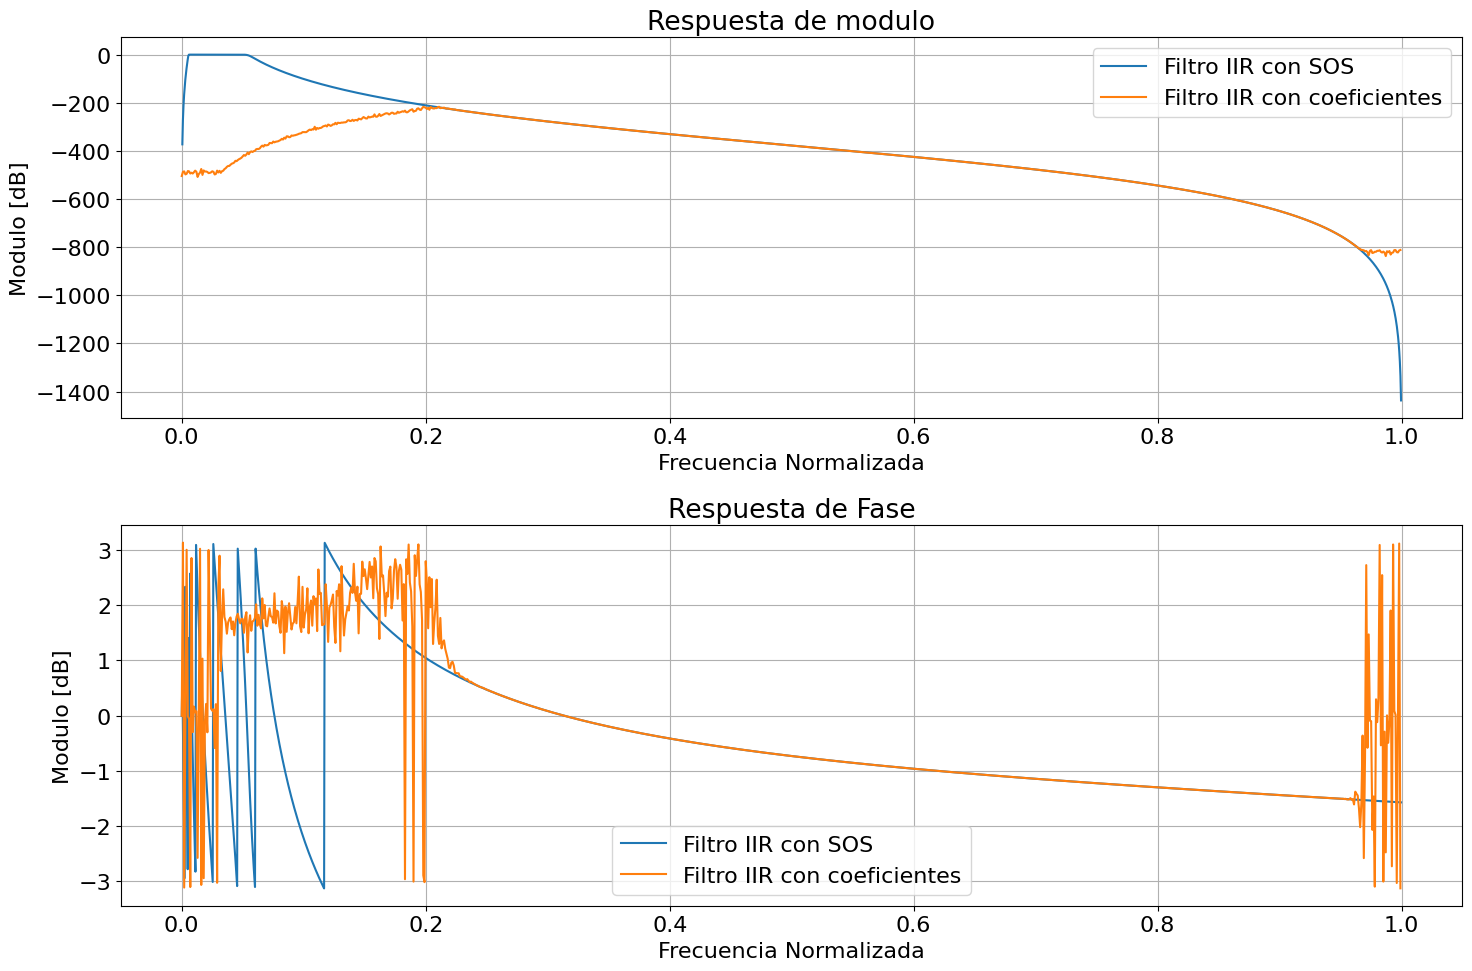

In [8]:
#Graficos
fig, ax = plt.subplots(2,1, figsize = (15,10))

#Grafico de modulo
ax[0].plot(ww, 20*np.log10(np.abs(hh)), label = 'Filtro IIR con SOS')
ax[0].plot(ww2, 20*np.log10(np.abs(hh2)), label = 'Filtro IIR con coeficientes')
ax[0].set_title('Respuesta de modulo')
ax[0].set_xlabel('Frecuencia Normalizada')
ax[0].set_ylabel('Modulo [dB]')
ax[0].grid()
ax[0].legend()

#Grafico de fase
ax[1].plot(ww, np.angle(hh), label = 'Filtro IIR con SOS')
ax[1].plot(ww2, np.angle(hh2), label = 'Filtro IIR con coeficientes')
ax[1].set_title('Respuesta de Fase')
ax[1].set_xlabel('Frecuencia Normalizada')
ax[1].set_ylabel('Modulo [dB]')
ax[1].grid()
ax[1].legend()

#Ajustar graficos
fig.tight_layout()

Se observa que en una parte del espectro las respuestas coinciden, pero en los extremos resultan muy diferentes.

Procedemos a variar la escala para hacer un zoom a los intervalos que nos interesan resaltar y calculamos el retardo de grupo para ambos casos:

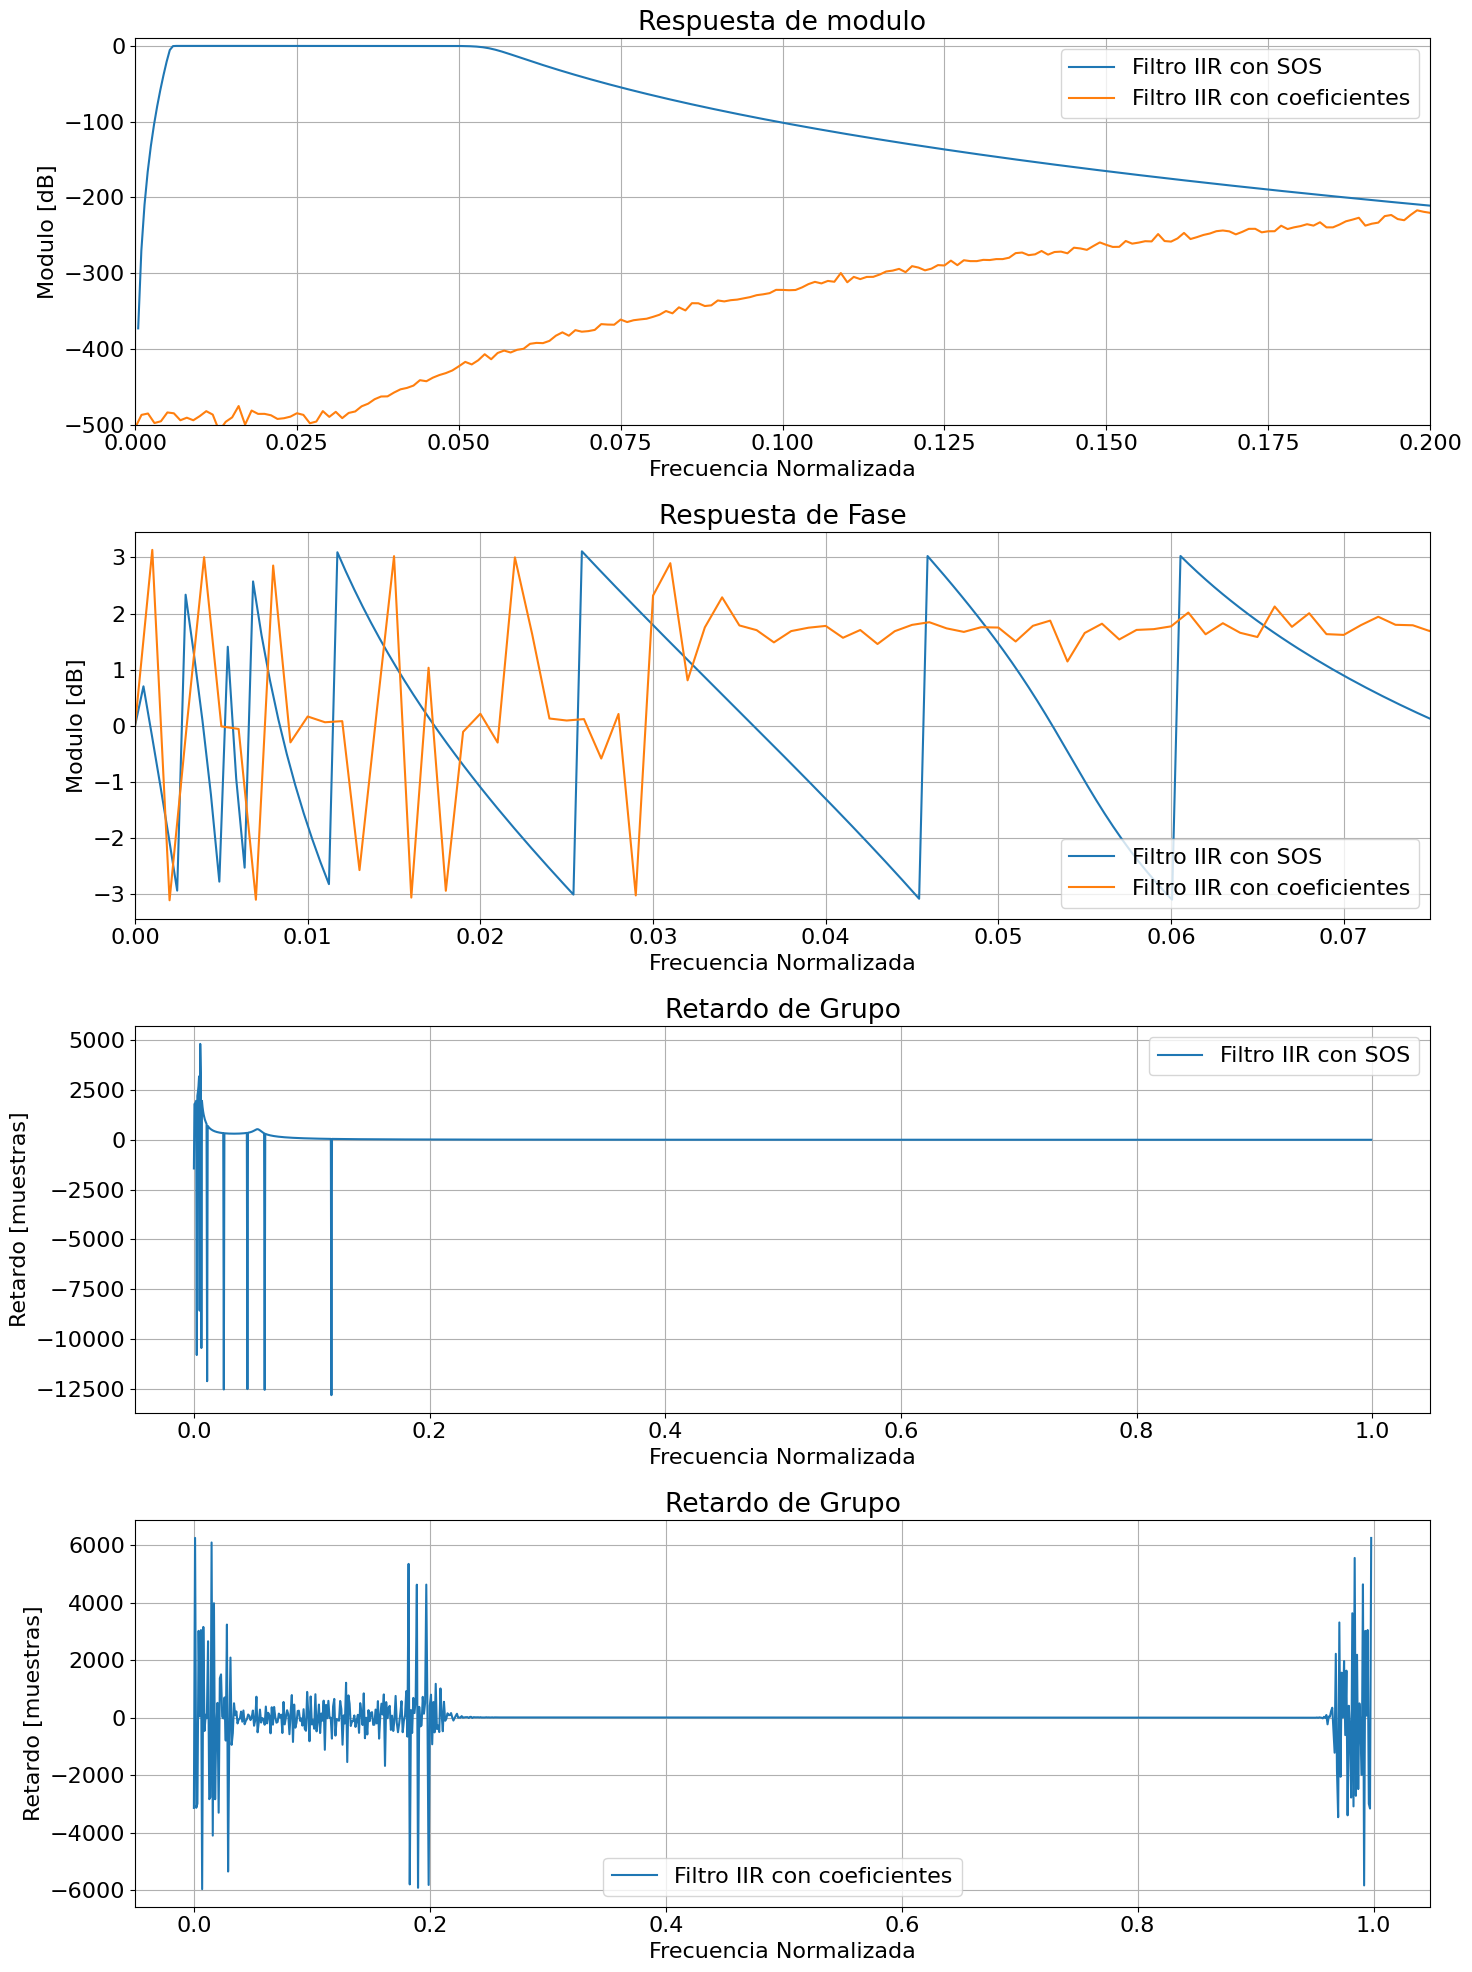

In [9]:
#Graficos
fig, ax = plt.subplots(4,1, figsize = (15,20))

#Grafico de modulo
ax[0].plot(ww, 20*np.log10(np.abs(hh)), label = 'Filtro IIR con SOS')
ax[0].plot(ww2, 20*np.log10(np.abs(hh2)), label = 'Filtro IIR con coeficientes')
ax[0].set_title('Respuesta de modulo')
ax[0].set_xlabel('Frecuencia Normalizada')
ax[0].set_ylabel('Modulo [dB]')
ax[0].grid()
ax[0].set_xlim([0,0.2])
ax[0].set_ylim([-500,10])
ax[0].legend()

#Grafico de fase
ax[1].plot(ww, np.angle(hh), label = 'Filtro IIR con SOS')
ax[1].plot(ww2, np.angle(hh2), label = 'Filtro IIR con coeficientes')
ax[1].set_title('Respuesta de Fase')
ax[1].set_xlabel('Frecuencia Normalizada')
ax[1].set_ylabel('Modulo [dB]')
ax[1].grid()
ax[1].set_xlim([0,0.075])
#ax[1].set_ylim([-500,10])
ax[1].legend()

#Grafico de retardo de grupo IIR
diff = -np.diff(np.angle(hh))/np.diff(ww)
ax[2].plot(ww[0:(len(ww)-1)], diff, label = 'Filtro IIR con SOS')
ax[2].set_title('Retardo de Grupo')
ax[2].set_xlabel('Frecuencia Normalizada')
ax[2].set_ylabel('Retardo [muestras]')
ax[2].grid()
ax[2].legend()

#Grafico de retardo de grupo IRR con coef
diff = -np.diff(np.angle(hh2))/np.diff(ww2)
ax[3].plot(ww2[0:(len(ww2)-1)], diff, label = 'Filtro IIR con coeficientes')
ax[3].set_title('Retardo de Grupo')
ax[3].set_xlabel('Frecuencia Normalizada')
ax[3].set_ylabel('Retardo [muestras]')
ax[3].grid()
ax[3].legend()


#Ajustar graficos
fig.tight_layout()


Finalmente nos quedamos con la transferencia devuelta en secciones de segundo orden.

<a name="1.2">
   <h2>1.2 Diseño filtro FIR</h2>
</a>


Nuevamente vamos a emplear otra de las funciones que provee la librería scipy.signal, para el filtro de respuesta finita la función para calcular los coeficientes es "firwin2":

##### scipy.signal.firwin2(numtaps, freq, gain, nfreqs=None, window='hamming', nyq=None, antisymmetric=False, fs=None)

Recibe:
* numtaps: Cantidad de Taps.
* freq: Puntos de frecuencias de muestreo en 
* gain: Vector de la misma forma que "bands" pero con los respectivos valores de ganancia por punto de muestreo.
* fs: Frecuencia de Sampling
Devuelve:
* coeffs: Coeficientes del filtro FIR.


In [10]:
numtaps = 1501
coeffs = sig.firwin2(numtaps, frecs, gains , window='blackmanharris')
print('Numero de taps del filtro FIR: {}'.format(len(coeffs)))

Numero de taps del filtro FIR: 1501


Empleamos nuevamente la función "freqz" para graficar y analizar la respuesta en frecuencia de la transferencia obtenida. En este caso el denominador es igual a 1 ya que los coeficientes "a" de un filtro FIR son nulos:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


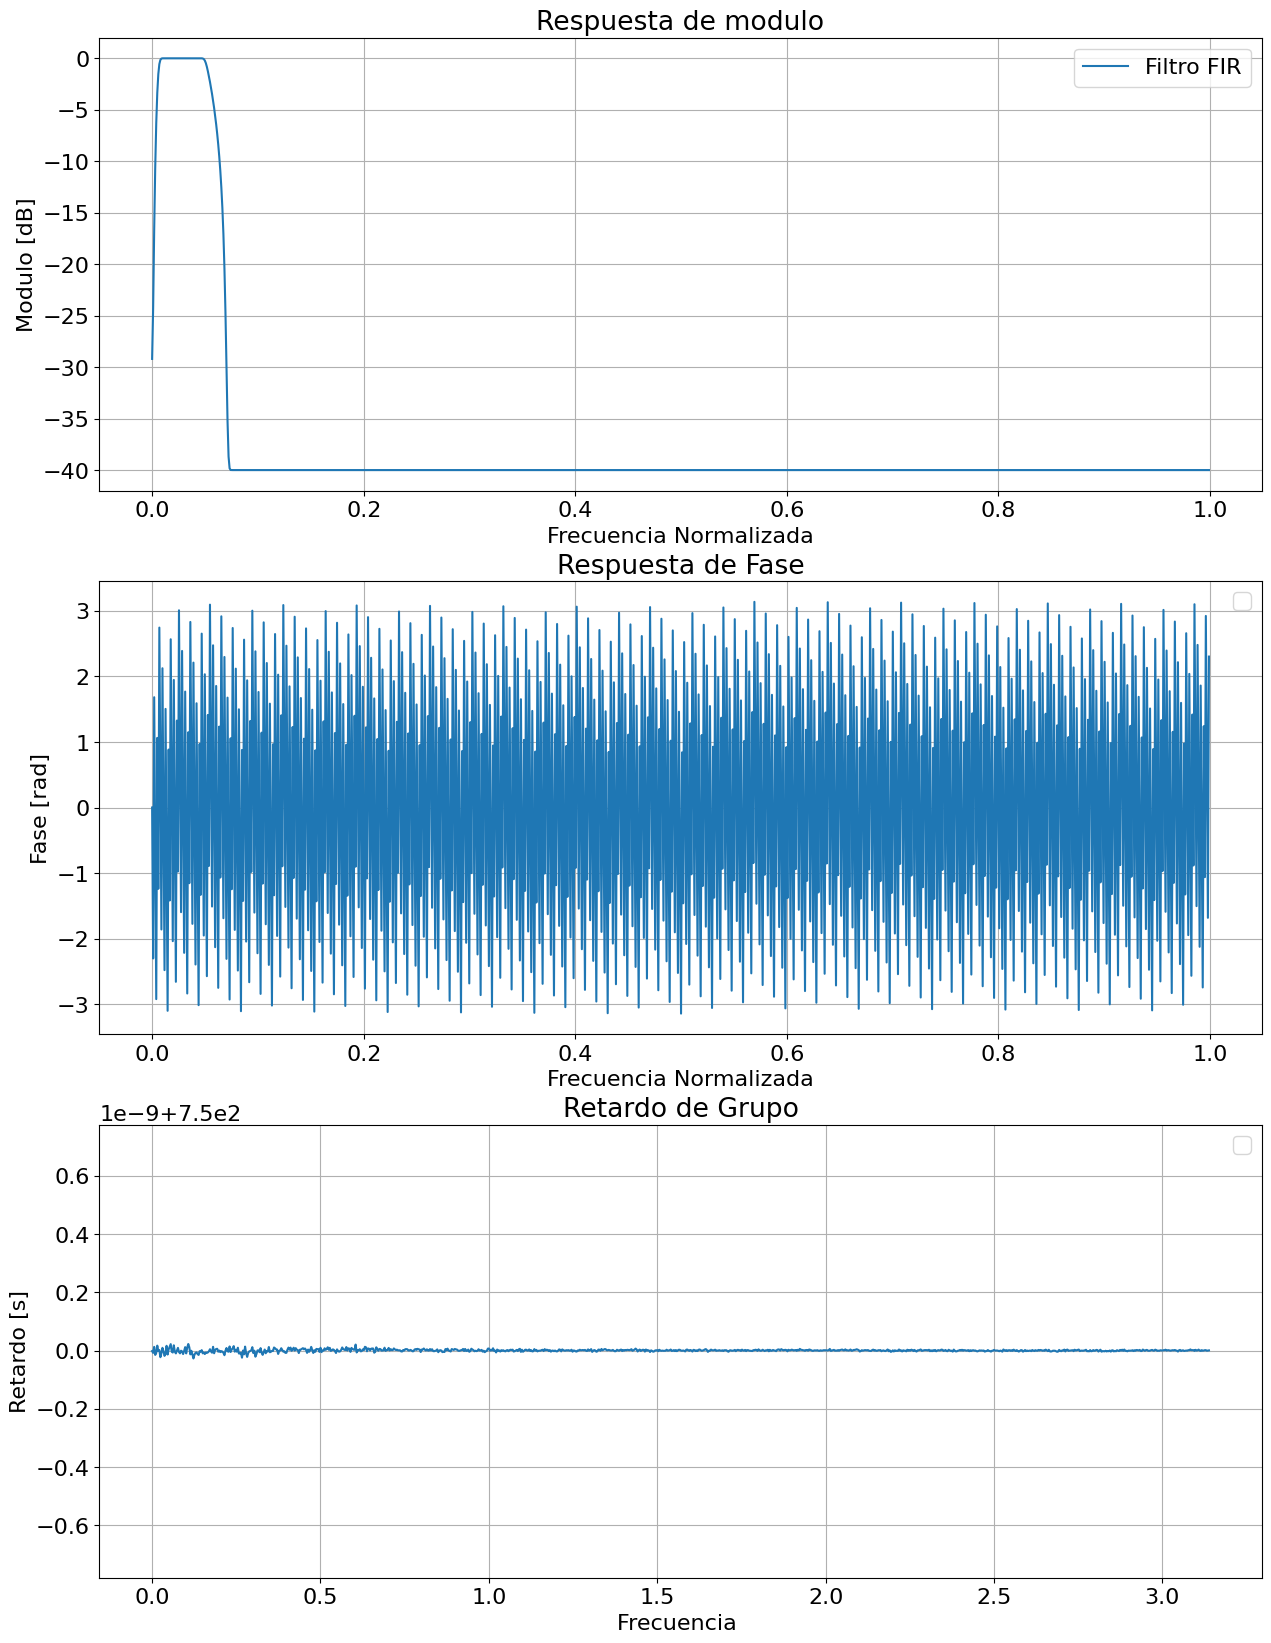

In [11]:
wrad3, hh3 = sig.freqz(coeffs, 1, worN=1024)#, fs=fs)

#Escalamos wrad para que vaya de 0 a 1
ww3 = wrad3 / np.pi

#Graficos
fig, ax = plt.subplots(3,1, figsize = (15,20))

#Grafico de modulo
ax[0].plot(ww3, 20*np.log10(np.abs(hh3)), label = 'Filtro FIR')
ax[0].set_title('Respuesta de modulo')
ax[0].set_xlabel('Frecuencia Normalizada')
ax[0].set_ylabel('Modulo [dB]')
ax[0].grid()
#ax[0].set_xlim([0,0.2])
#ax[0].set_ylim([-500,10])
ax[0].legend()

#Grafico de fase
ax[1].plot(ww3, np.angle(hh3))
ax[1].set_title('Respuesta de Fase')
ax[1].set_xlabel('Frecuencia Normalizada')
ax[1].set_ylabel('Fase [rad]')
ax[1].grid()
#ax[1].set_xlim([0,0.075])
#ax[1].set_ylim([-500,10])
ax[1].legend()

#Grafico de retardo de grupo
wz, d = sig.group_delay((coeffs,1), w=wrad3, fs = fs)
ax[2].plot(wz, d)
ax[2].set_title('Retardo de Grupo')
ax[2].set_xlabel('Frecuencia ')
ax[2].set_ylabel('Retardo [s]')
ax[2].grid()
#ax[2].set_xlim([0,100])
#ax[2].set_ylim([700,800])
ax[2].legend()


Caracteristico del filtro FIR, se detaca la linealidad que presenta el retardo de grupo. 

Procedemos a graficar las respuestas de modulo superpuestas y desnormalizadas para verificar los requisitos de la plantilla:

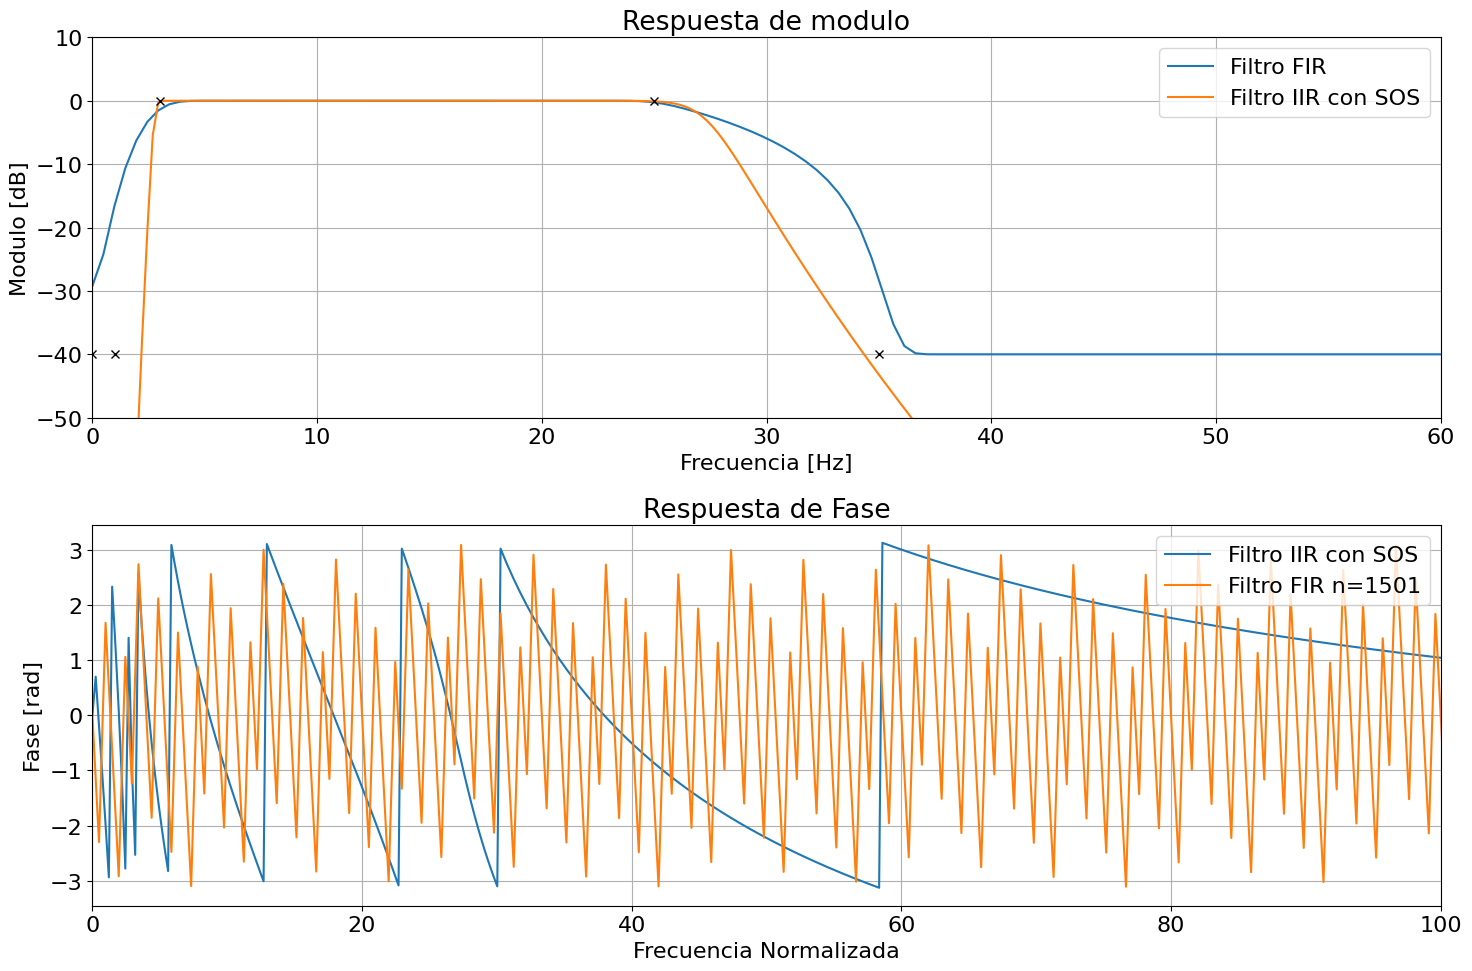

In [16]:
#Graficos
fig, ax = plt.subplots(2,1, figsize = (15,10))

#Grafico de modulo
ax[0].plot(wrad3/ np.pi * nyq_frec, 20*np.log10(np.abs(hh3)), label = 'Filtro FIR')
ax[0].plot(ww*nyq_frec, 20*np.log10(np.abs(hh)), label = 'Filtro IIR con SOS')
ax[0].set_title('Respuesta de modulo')
ax[0].set_xlabel('Frecuencia [Hz]')
ax[0].set_ylabel('Modulo [dB]')
ax[0].grid()
ax[0].set_xlim([0,60])
ax[0].set_ylim([-50,10])
ax[0].legend()
#Limites plantilla
ax[0].plot(0,-40,1,-40,3,0,25,0,35,-40, marker='x', color = 'k')

#Grafico de fase
ax[1].plot(ww*nyq_frec, np.angle(hh), label = 'Filtro IIR con SOS')
ax[1].plot(wrad3/ np.pi* nyq_frec, np.angle(hh3), label='Filtro FIR n=1501')
ax[1].set_title('Respuesta de Fase')
ax[1].set_xlabel('Frecuencia Normalizada')
ax[1].set_ylabel('Fase [rad]')
ax[1].set_xlim([0,100])
ax[1].grid()
ax[1].legend()

#Ajustar graficos
fig.tight_layout()

<div class="alert alert-success text-left">
<img src="./rsc/logo_UTN.svg" align="right" width="150" /> 
<center> 
    <a name="parte2">
        <h1> PARTE 2</h1>
    </a> 
</center>
</div>


Cargamos el archivo que contiene los datos de la señal ECG registrada a 1 kHz, con contaminación de diversos origenes:

In [17]:
mat_struct = sio.loadmat('ecg.mat')
ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)
cant_muestras

1129116

<a name="2.1">
   <h2>2.1 Filtado con IIR</h2>
</a>



Para efectuar el filtrado de la señal utilizamos la función "sosfilt" para filtros IIR de orden superior (más de 3 secciones):

In [14]:
filtrado_IIR = sig.sosfilt(H_z, ecg_one_lead)

Procedemos a visualizar las zonas de alta contaminación para evaluar que la eficiencia del filtrado:

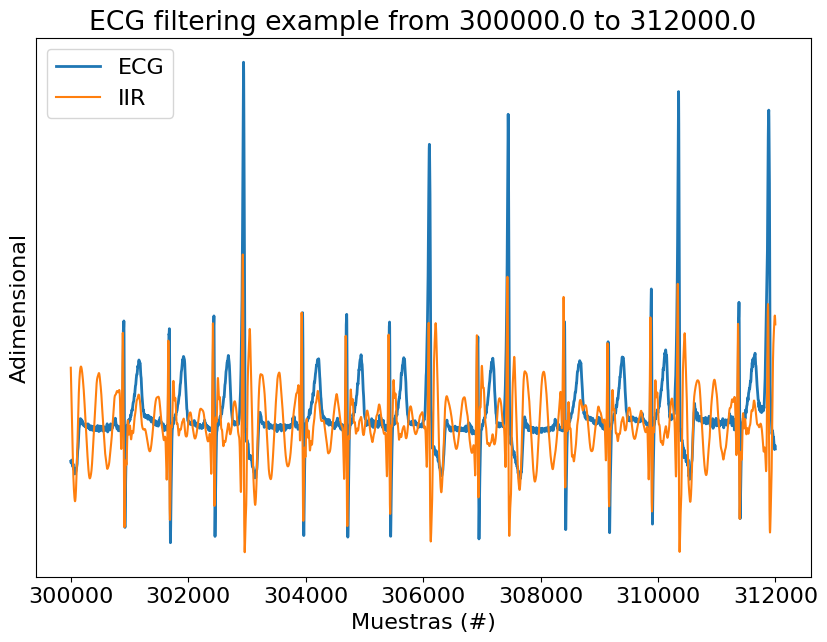

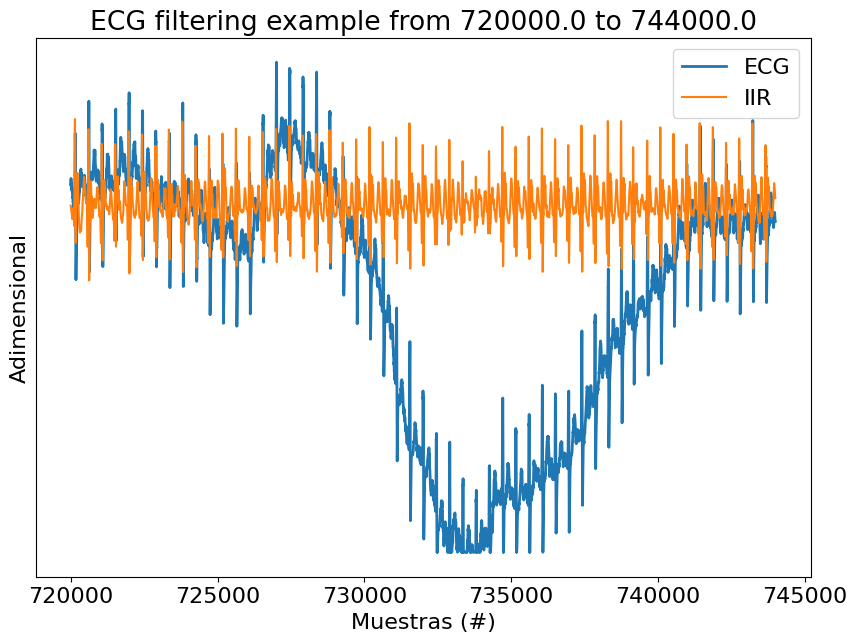

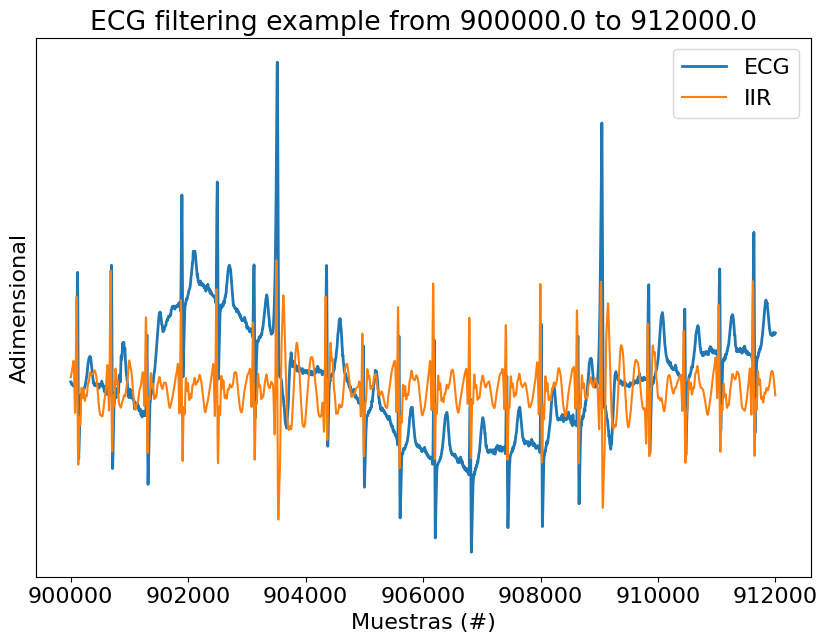

In [15]:
demora = 125

# Segmentos de interés con ALTA contaminación
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, filtrado_IIR[zoom_region + demora], label='IIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Se observa que la señal ECG posee contaminación en baja frecuencia 

<a name="2.2">
   <h2>2.2 Filtado con FIR</h2>
</a>

Para efectuar el filtrado de la señal utilizamos la función "lfilter" para filtros FIR de cualquier orden:

In [18]:
filtrado_FIR = sig.lfilter(coeffs, 1, ecg_one_lead)

In [ ]:
Procedemos a visualizar las zonas de alta contaminación para evaluar que la eficiencia del filtrado:

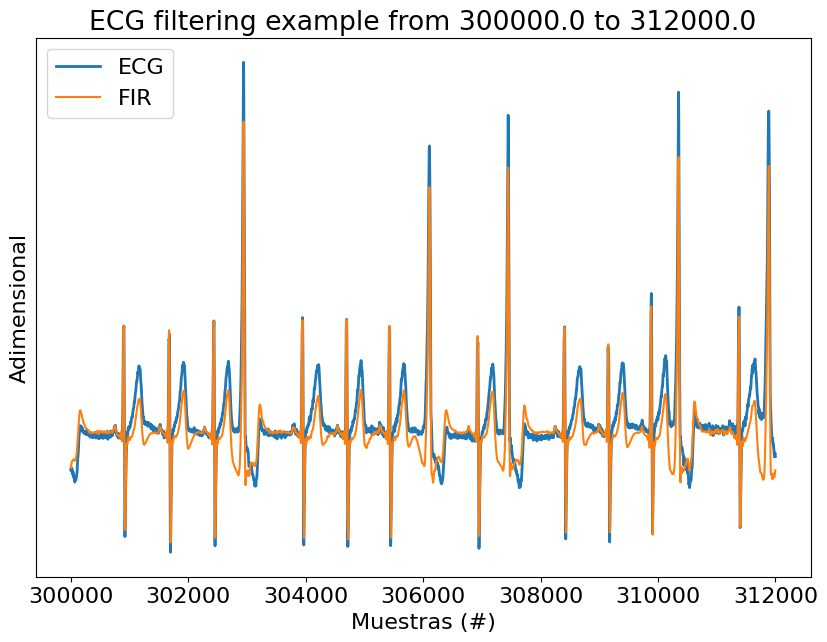

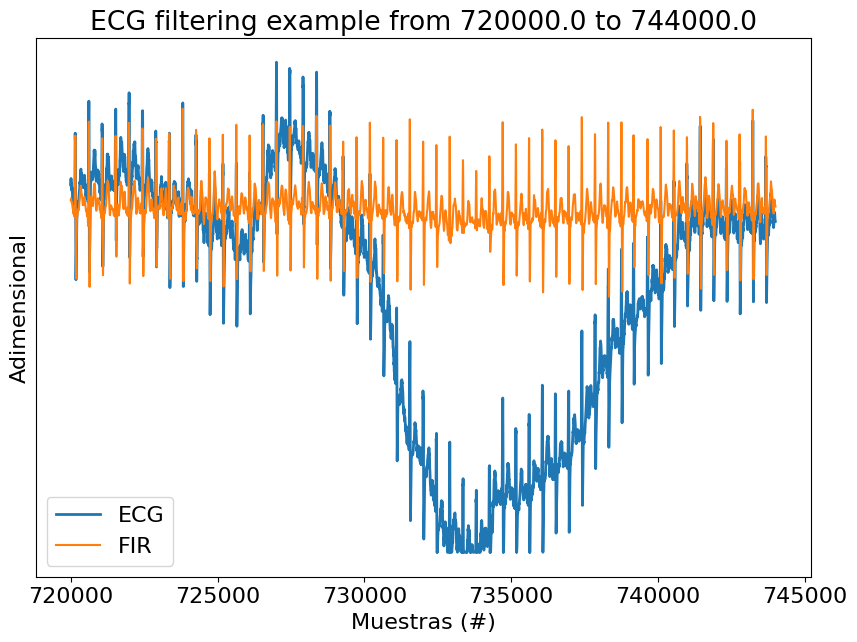

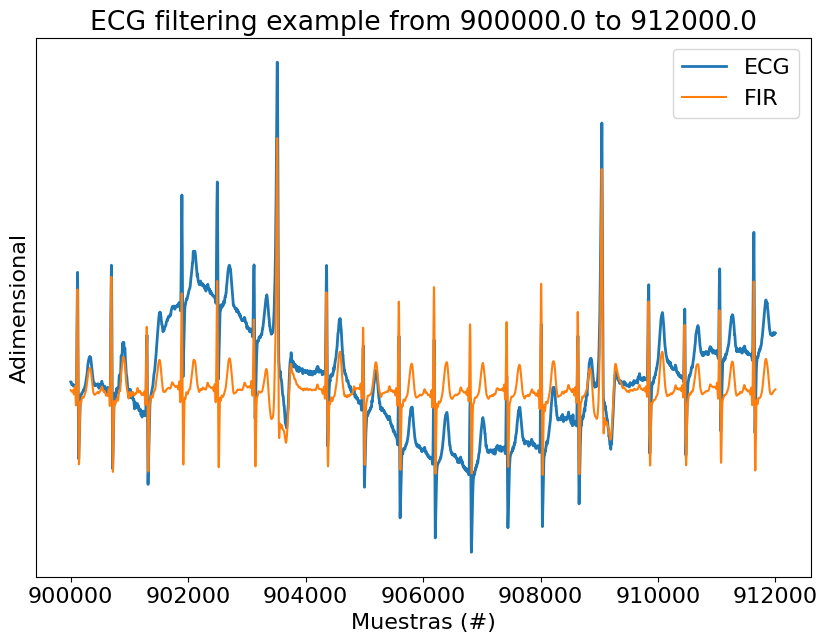

In [23]:
demora = 750

# Segmentos de interés con ALTA contaminación
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, filtrado_FIR[zoom_region + demora], label='FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

<a name="2.3">
   <h2>2.3 Filtrado en banda de paso</h2>
</a>

Ahora analizaremos cómo se han comportado los filtros analizando la señal en detalle para algunos latidos con baja contaminación, es decir qué tan inocuo es el filtro en su banda de paso. Desde luego nos interesará que la señal de ECG no haya sido alterada en su morfología, debido a que esto podría imposibilitar su uso como método de diagnóstico.

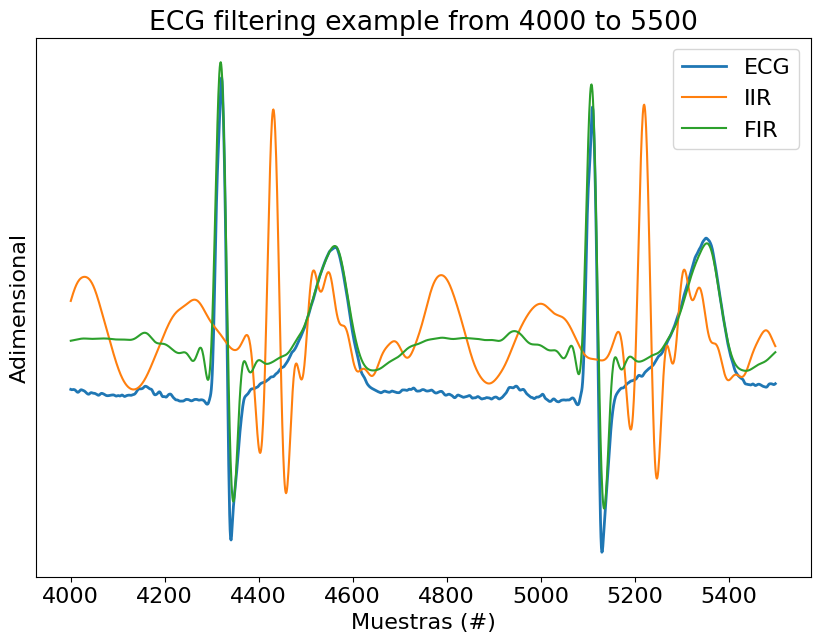

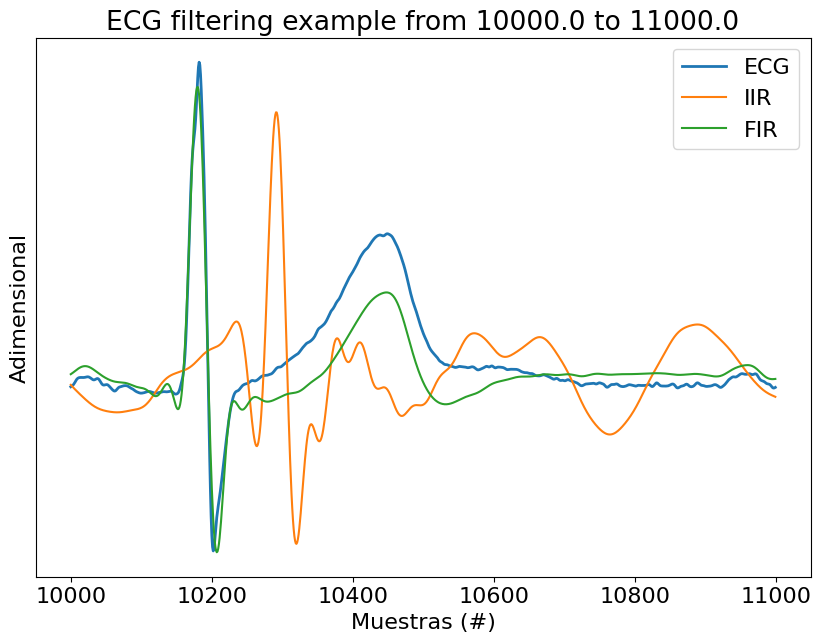

In [24]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, filtrado_IIR[zoom_region], label='IIR')
    plt.plot(zoom_region, filtrado_FIR[zoom_region + demora], label='FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()